# Prepare some things

## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import numpy as np

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

2023-06-02 20:27:26.120228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the model class and some custom functions
import sys
sys.path.append('../')
from models import get_vae_model, get_clustering_vae_model, compute_p, compute_delta
from clustering_metrics import evaluate_model
from draw_embeddings import draw_embeddings, draw_matched_labels, compare_reconstructed_images_MNIST

In [3]:
# Disable warnings output (TSNE outputs one very time)
import warnings
warnings.filterwarnings('ignore')

## Load and prepare the MNIST data set

In [4]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test  = x_test.reshape(-1, 28*28).astype("float")/255

# Pretrain the model

## Construct and pretrain the autoencoder

In [5]:
IMG_DIM    = 28*28
LATENT_DIM = 10
INTERMEDIATE_DIMS = (512, 512, 2048)

# EPOCHS        = 100 # Recommended number of epochs
EPOCHS        = 5 # Just to test that it works
BATCH_SIZE    = 128
LEARNING_RATE = 1e-4
# MOMENTUM      = 0.9

model_vae = get_vae_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)

# model_vae.encoder.summary()
# model_vae.decoder.summary()

2023-06-02 20:27:28.724301: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
model_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
# model_vae.compile(optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM))

model_vae.fit(x          = x_train,
              epochs     = EPOCHS,
              batch_size = BATCH_SIZE,
              verbose    = 1,
              )

model_vae.save_weights("model_weights/cvae/pretrained/vae")
# model_vae.load_weights("model_weights/cvae/pretrained/vae")

Epoch 1/5
469/469 [==============================] - 45s 93ms/step - total_loss: 37.5739 - reg_loss: 0.4662 - rec_loss: 37.1077
Epoch 2/5
469/469 [==============================] - 48s 102ms/step - total_loss: 32.8259 - reg_loss: 0.7950 - rec_loss: 32.0309
Epoch 3/5
469/469 [==============================] - 47s 100ms/step - total_loss: 31.9510 - reg_loss: 1.2028 - rec_loss: 30.7483
Epoch 4/5
469/469 [==============================] - 48s 103ms/step - total_loss: 31.6528 - reg_loss: 1.3517 - rec_loss: 30.3011
Epoch 5/5
469/469 [==============================] - 46s 98ms/step - total_loss: 31.0028 - reg_loss: 1.8704 - rec_loss: 29.1324


## Show the resulting embeddings

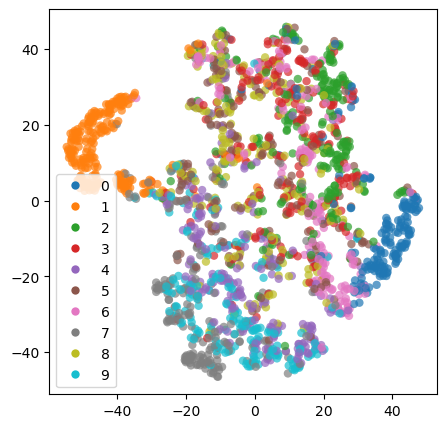

In [7]:
if LATENT_DIM == 2:
    z_test = model_vae.encode_only_mu(x_test)
    draw_embeddings(z_test, y_test)
else:
    z_test = model_vae.encode_only_mu(x_test)
    tsne   = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_embeddings(z_tsne, y_test[0:2000])

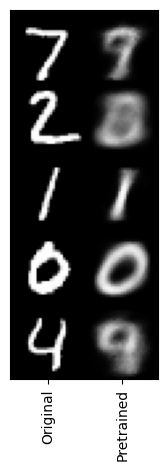

In [8]:
compare_orig_vs_pretrained = compare_reconstructed_images_MNIST(x_test, model_vae.encoder, model_vae.decoder, ("Original", "Pretrained"))

# Fine-tune the model (K-Means)

## Construct the full VaDE model

Load the pretrained weights for the encoder and decoder modules:

In [9]:
# model_vae.load_weights("model_weights/cvae/pretrained/vae")

Construct the VaDE model:

In [10]:
N_CLUSTERS = 10
CLUSTERING_LOSS_WEIGHT = 1

# EPOCHS          = 100 # Recommended number of epochs
EPOCHS          = 5 # Just to test that it works
BATCH_SIZE      = 128
LEARNING_RATE   = 1e-4
SCHEDULE        = 10
DELTA_THRESHOLD = 0.001

model_cvae = get_clustering_vae_model(model_vae, N_CLUSTERS, CLUSTERING_LOSS_WEIGHT)

## Initialize the parameters

Initialize the model parameters from a K-means:

In [11]:
z_train = model_cvae.encode_only_mu(x_train)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
kmeans.fit(z_train)

for weight in model_cvae.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(kmeans.cluster_centers_))

Initialize `p`, the auxiliary distribution to compute the clustering loss, and `c_last`, the last cluster assignments to compute the number of points that changed clusters.

In [12]:
p      = compute_p(to_categorical(kmeans.labels_))
c_last = kmeans.labels_

Evaluate the clustering performance before fine-tunning the model:

In [13]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train, centroids=kmeans.cluster_centers_)

{'Acc': 0.4052,
 'ARI': 0.2293465259791744,
 'AMI': 0.33479810948512234,
 'Sil': 0.10123441}

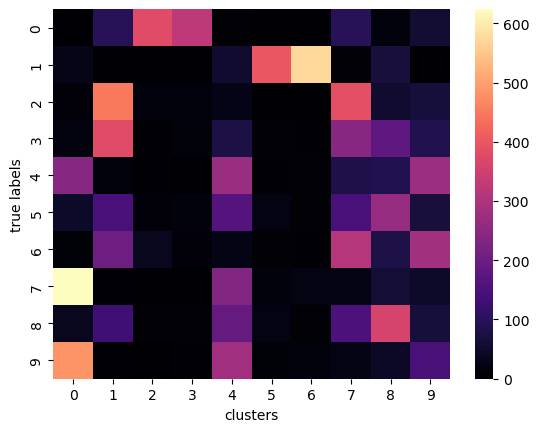

In [14]:
evaluate_model(x_test, y_test, model_cvae.classify, model_cvae.encode_only_mu)

## Train the model

Train the model:

In [15]:
def cvae_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_cvae.soft_assignment(x_train)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        print(f"Delta: {delta:.3f}")
        
        if (delta < DELTA_THRESHOLD):
            model_cvae.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=cvae_callback)

In [16]:
model_cvae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

model_cvae.fit(x          = x_train,
               y          = p,
               epochs     = EPOCHS,
               batch_size = BATCH_SIZE,
               callbacks  = callback,
               verbose    = 1,
              )

model_cvae.save_weights("model_weights/cvae/finetuned/cvae_kmeans")
# model_cvae.load_weights("model_weights/cvae/finetuned/cvae_kmeans")

Epoch 1/5
469/469 [==============================] - 44s 91ms/step - total_loss: 41.8530 - reg_loss: 2.4469 - rec_loss: 27.9059 - clust_loss: 11.5003
Epoch 2/5
469/469 [==============================] - 43s 91ms/step - total_loss: 41.2884 - reg_loss: 2.8657 - rec_loss: 26.9440 - clust_loss: 11.4787
Epoch 3/5
469/469 [==============================] - 43s 91ms/step - total_loss: 40.5698 - reg_loss: 3.4873 - rec_loss: 25.6314 - clust_loss: 11.4510
Epoch 4/5
469/469 [==============================] - 42s 89ms/step - total_loss: 40.0719 - reg_loss: 3.8561 - rec_loss: 24.7949 - clust_loss: 11.4209
Epoch 5/5
469/469 [==============================] - 49s 104ms/step - total_loss: 39.7424 - reg_loss: 4.0999 - rec_loss: 24.2499 - clust_loss: 11.3926


## Show the resulting embeddings

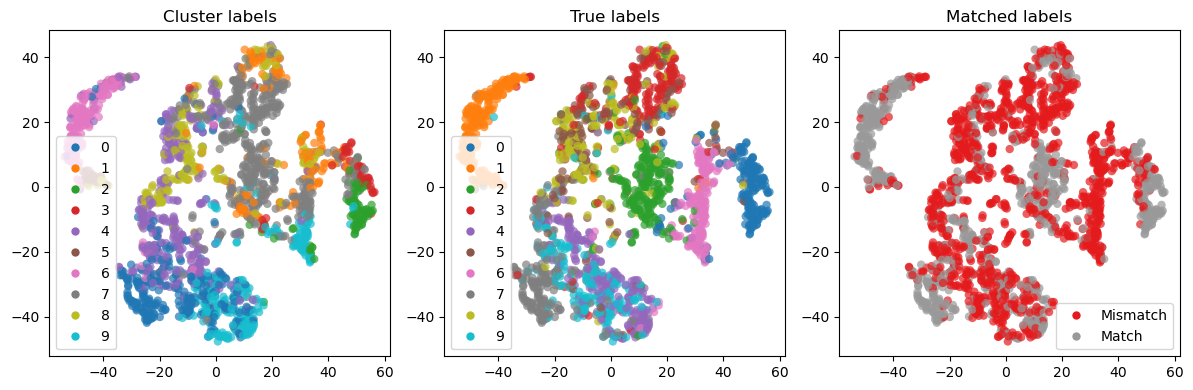

In [17]:
z_test = model_cvae.encode_only_mu(x_test)
c_test = model_cvae.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne   = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_matched_labels(z_tsne, y_test[0:2000], c_test[0:2000])

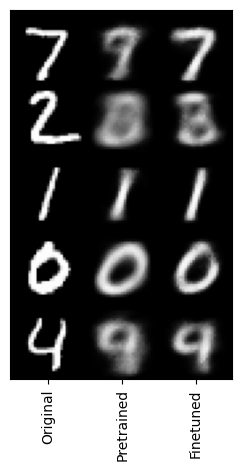

In [18]:
_ = compare_reconstructed_images_MNIST(x_test, model_cvae.encoder, model_cvae.decoder, ("Original", "Pretrained", "Finetuned"), old_figure=compare_orig_vs_pretrained)

## Evaluate the model

{'Acc': 0.4331,
 'ARI': 0.2394163372745388,
 'AMI': 0.3738006384522351,
 'Sil': 0.0976706}

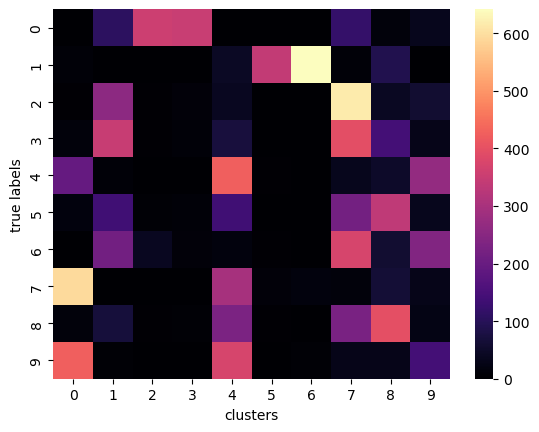

In [19]:
evaluate_model(x_test, y_test, model_cvae.classify, model_cvae.encode_only_mu)

# Fine-tune the model (GMM)

## Construct the model and load the pretrained weights

Load the pretrained weights for the encoder and decoder modules:

In [20]:
model_vae.load_weights("model_weights/cvae/pretrained/vae")

In [21]:
N_CLUSTERS = 10
CLUSTERING_LOSS_WEIGHT = 1

# EPOCHS          = 100 # Recommended number of epochs
EPOCHS          = 5 # Just to test that it works
BATCH_SIZE      = 128
LEARNING_RATE   = 1e-5
SCHEDULE        = 10
DELTA_THRESHOLD = 0.001

model_cvae = get_clustering_vae_model(model_vae, N_CLUSTERS, CLUSTERING_LOSS_WEIGHT)

## Initialize the parameters

In [22]:
z_train = model_cvae.encode_only_mu(x_train)

gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag')
gmm.fit(z_train)

for weight in model_cvae.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(gmm.means_))

In [23]:
p      = compute_p(to_categorical(gmm.predict(z_train)))
c_last = gmm.predict(z_train)

Evaluate the clustering performance before fine-tunning the model:

In [24]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train, centroids=gmm.means_)

{'Acc': 0.3626,
 'ARI': 0.20382639937756672,
 'AMI': 0.27500664127919866,
 'Sil': 0.01613343}

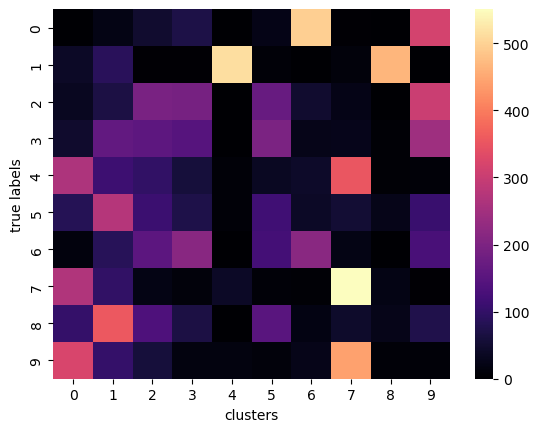

In [25]:
evaluate_model(x_test, y_test, model_cvae.classify, model_cvae.encode_only_mu)

## Train the model

In [26]:
model_cvae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

model_cvae.fit(x          = x_train,
               y          = p,
               epochs     = EPOCHS,
               batch_size = BATCH_SIZE,
               callbacks  = callback,
               verbose    = 1,
              )

model_cvae.save_weights("model_weights/cvae/finetuned/cvae_gmm")
# model_cvae.load_weights("model_weights/cvae/finetuned/cvae_gmm")

Epoch 1/5
469/469 [==============================] - 44s 92ms/step - total_loss: 42.1733 - reg_loss: 2.2682 - rec_loss: 28.1975 - clust_loss: 11.7077
Epoch 2/5
469/469 [==============================] - 42s 90ms/step - total_loss: 42.0827 - reg_loss: 2.3247 - rec_loss: 28.0646 - clust_loss: 11.6934
Epoch 3/5
469/469 [==============================] - 43s 92ms/step - total_loss: 42.0207 - reg_loss: 2.3618 - rec_loss: 27.9699 - clust_loss: 11.6889
Epoch 4/5
469/469 [==============================] - 43s 92ms/step - total_loss: 41.9686 - reg_loss: 2.4078 - rec_loss: 27.8783 - clust_loss: 11.6825
Epoch 5/5
469/469 [==============================] - 42s 90ms/step - total_loss: 41.9033 - reg_loss: 2.4399 - rec_loss: 27.7862 - clust_loss: 11.6772


## Show the resulting embeddings

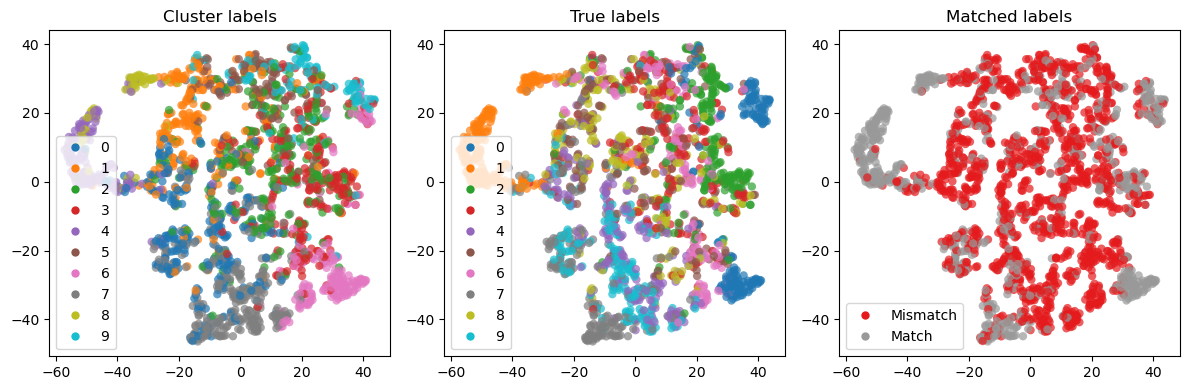

In [27]:
z_test = model_cvae.encode_only_mu(x_test)
c_test = model_cvae.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne   = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_matched_labels(z_tsne, y_test[0:2000], c_test[0:2000])

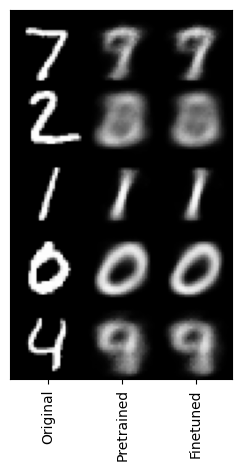

In [28]:
_ = compare_reconstructed_images_MNIST(x_test, model_cvae.encoder, model_cvae.decoder, ("Original", "Pretrained", "Finetuned"), old_figure=compare_orig_vs_pretrained)

## Evaluate the model

{'Acc': 0.3803,
 'ARI': 0.20604214146451455,
 'AMI': 0.2981009979972419,
 'Sil': 0.051448714}

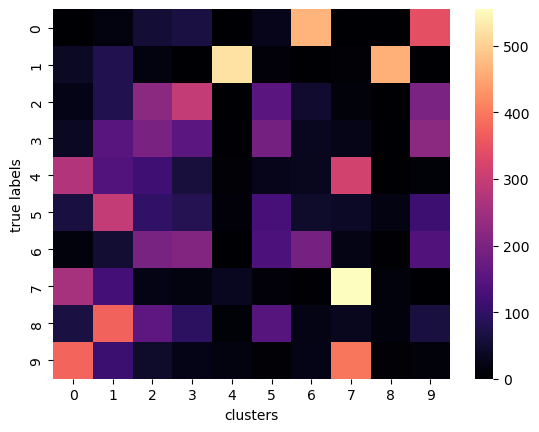

In [29]:
evaluate_model(x_test, y_test, model_cvae.classify, model_cvae.encode_only_mu)